# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

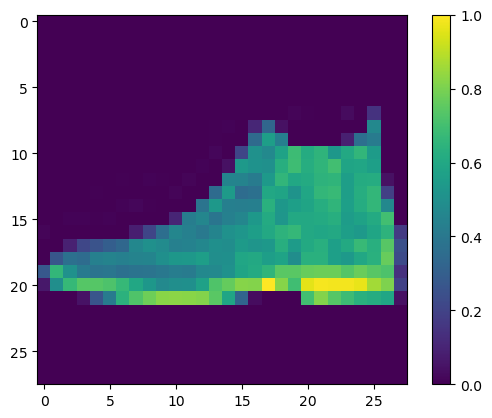

In [6]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

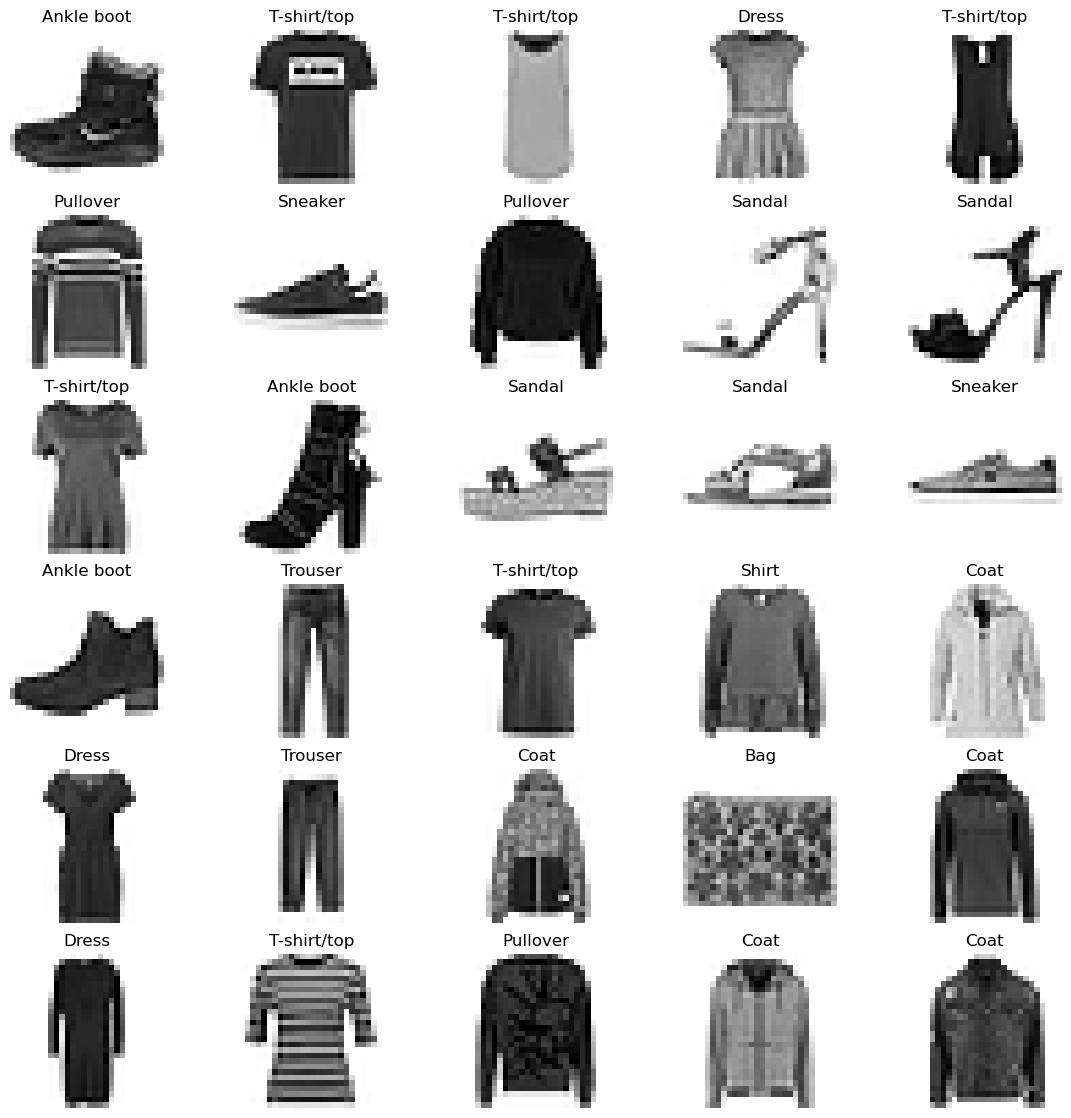

In [7]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

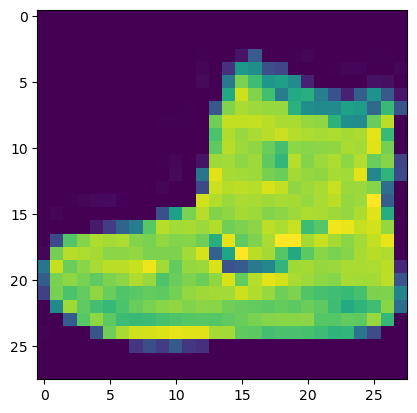

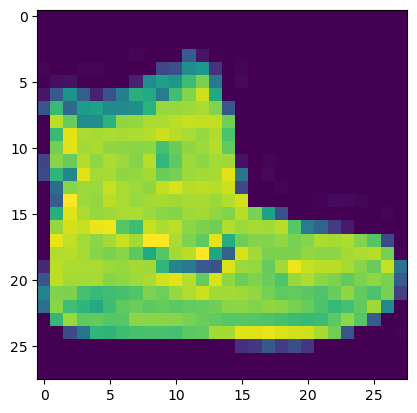

In [8]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


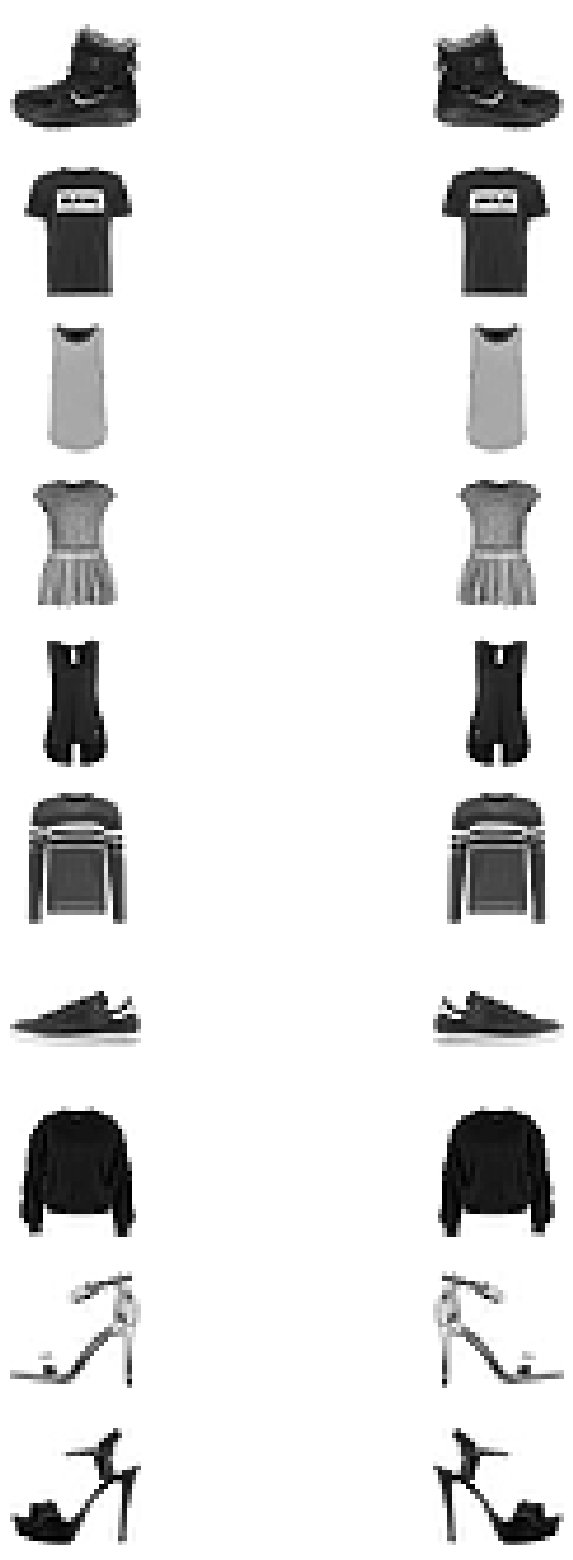

In [9]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

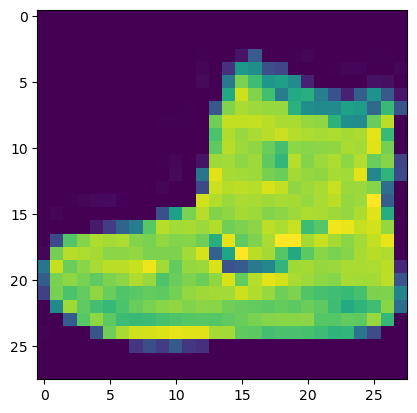

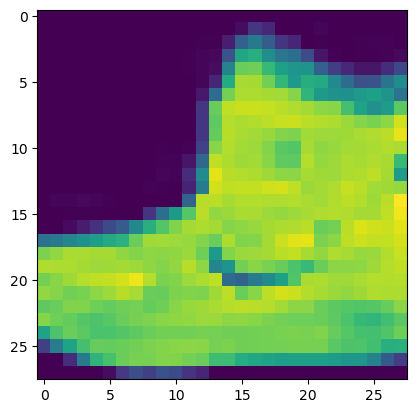



(54000, 28, 28)


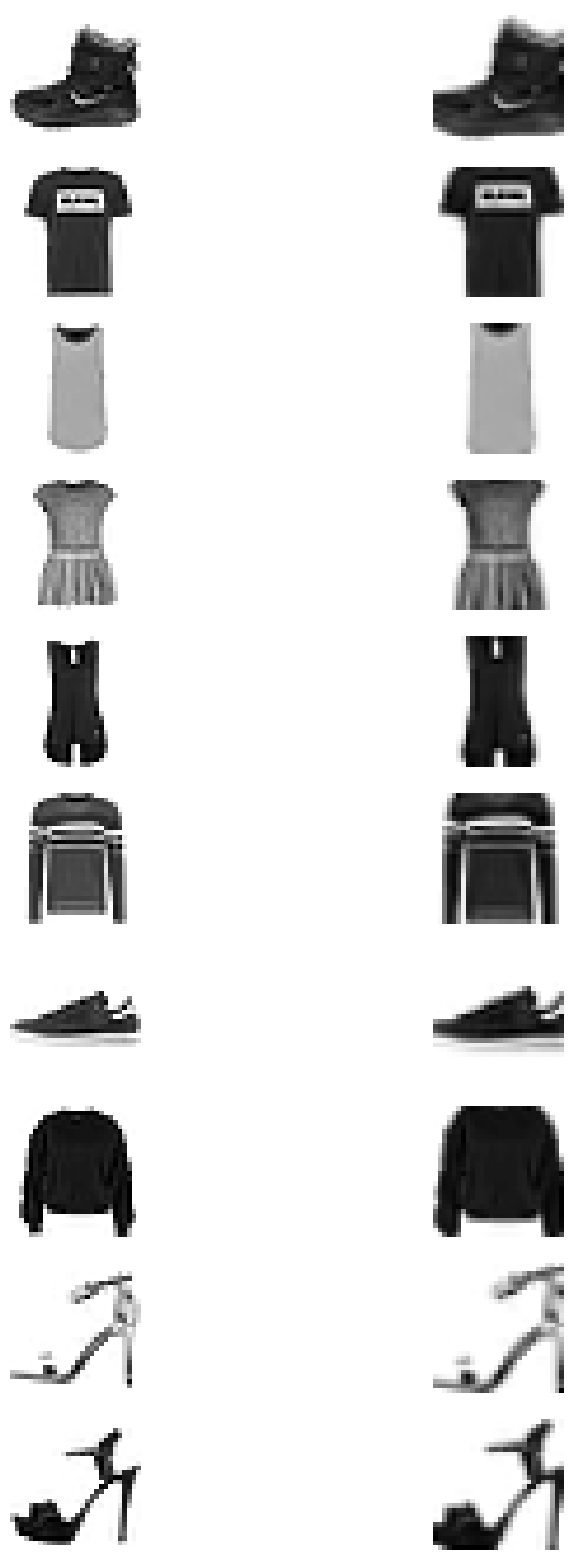

In [10]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [12]:
model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

baseline_history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
baseline_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 25, 25, 64)        1088      
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               5120128   
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


UnimplementedError: Graph execution error:

Detected at node 'sequential/conv2d_53/Relu' defined at (most recent call last):
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\P2100803\AppData\Local\Temp\ipykernel_1724\2354074892.py", line 16, in <cell line: 16>
      baseline_history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\P2100803\.conda\envs\gpu_env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d_53/Relu'
DNN library is not found.
	 [[{{node sequential/conv2d_53/Relu}}]] [Op:__inference_train_function_4276]

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3246 - accuracy: 0.8978


[0.32464656233787537, 0.8978000283241272]

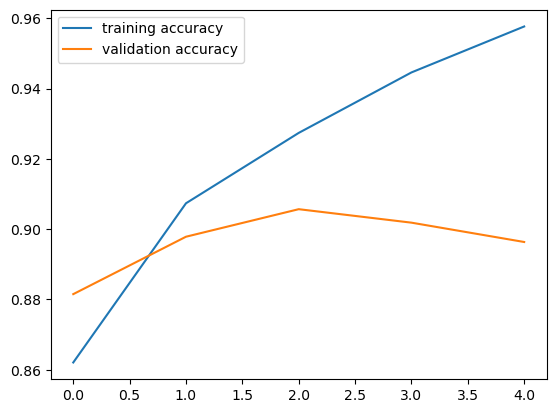

In [ ]:
plt.plot(baseline_history.history['accuracy'], label='training accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='validation accuracy')
plt.legend()

plt.show()

#### baseline model containing simple Conv2D layer gets testing accuracy of 90%

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Resnet50

In [11]:
# ATTENTION. train using school lab computer with GPU

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50():
    input_im = Input(shape=(28,28,1)) # cifar 10 images size
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

resnet50_model = resnet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [ ]:
import scipy
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_lab_categorical = tf.keras.utils.to_categorical(
    y_train, num_classes=10, dtype='uint8')

train_set_conv = train_DataGen.flow(x_train.reshape((*x_train.shape,1)), train_lab_categorical, batch_size=batch_size)

resnet_history = resnet50_model.fit(train_set_conv, epochs=100)

Epoch 1/100
 64/844 [=>............................] - ETA: 8:37 - loss: 19.1176 - acc: 0.4399

KeyboardInterrupt: 

<h3><b>4. Model Improvement</h3></b>

In [ ]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [ ]:
baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=5, validation_data=(x_val, y_val))
baseline_augmented_history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               5120128   
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 31s 6ms/step - loss: 0.3626 - accuracy: 0.8677 - val_loss: 0.2985 - val_accuracy: 0.8882
Epoch 2/5
5063/5063 [======

In [ ]:
baseline_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.9104


[0.38691049814224243, 0.9103999733924866]

In [ ]:
# baseline_augmented_model.save_weights("baseline_augmented_model.h5")

In [ ]:
# resnet 50 but augmented data

resnet50_augmented_model = resnet50()
resnet50_augmented_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

train_augmented_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_labels_augmented_categorical = tf.keras.utils.to_categorical(
    y_train_augmented, num_classes=10, dtype='uint8')

train_augmented_set_conv = train_augmented_DataGen.flow(x_train_augmented.reshape((*x_train_augmented.shape,1)), train_labels_augmented_categorical, batch_size=batch_size)

resnet_history = resnet50_model.fit(train_augmented_set_conv, epochs=100)

NameError: name 'y_train_augmented' is not defined